In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.losses import BinaryCrossentropy

# Carga de datos

In [3]:
df = pd.read_csv('../data/USA_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 552 entries, 1976-12-01 to 2022-11-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   INDPRO     552 non-null    float64
 1   PAYEMS     552 non-null    float64
 2   UNRATENSA  552 non-null    float64
 3   MPRIME     552 non-null    float64
 4   TOTALSA    552 non-null    float64
 5   Class      552 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 30.2 KB


In [5]:
df.describe()

,INDPRO,PAYEMS,UNRATENSA,MPRIME,TOTALSA,Class
count,552.000000,552.000000,552.000000,552.000000,5.520000e+02,552.000000
mean,0.001504,0.001188,0.001758,-0.000092,-6.503275e-07,0.115942
std,0.003272,0.001763,0.017313,0.018738,8.059840e-03,0.320446
min,-0.012309,-0.006452,-0.096487,-0.051722,-3.474568e-02,0.000000
25%,0.000322,0.000509,-0.003765,-0.009446,-3.181993e-03,0.000000
50%,0.002075,0.001442,0.005265,0.000082,7.457537e-04,0.000000
75%,0.003471,0.002111,0.009246,0.013065,5.037476e-03,0.000000
max,0.008630,0.004349,0.054615,0.048879,1.919342e-02,1.000000


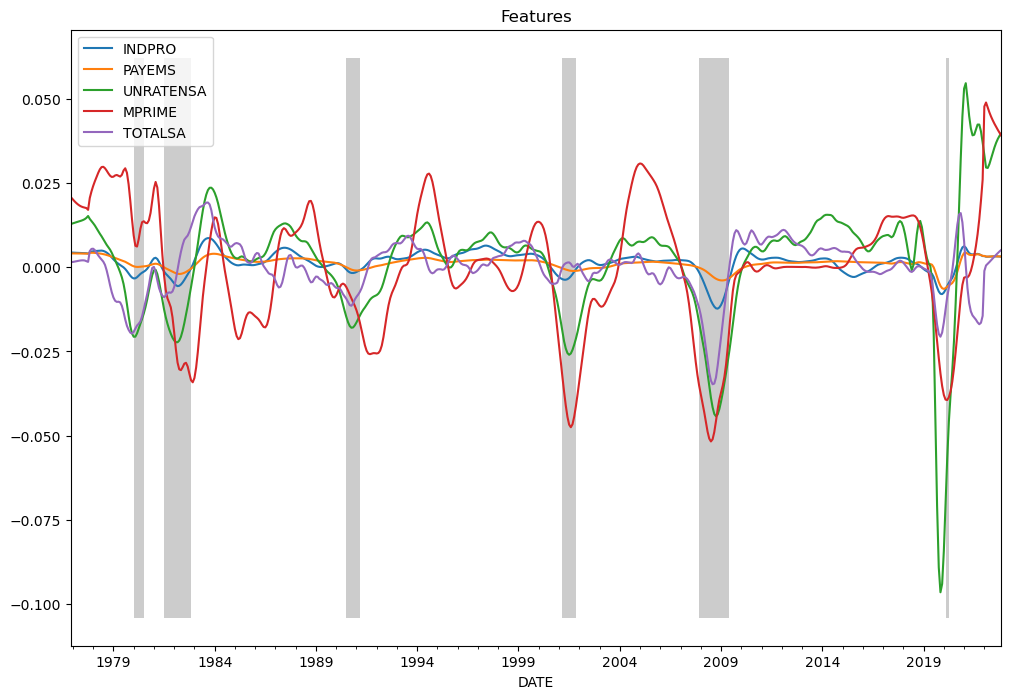

In [6]:
graficarTodo(df,'Features')

# Mostrar Imbalance de clases

In [7]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 552
    Positive: 64 (11.59% of total)



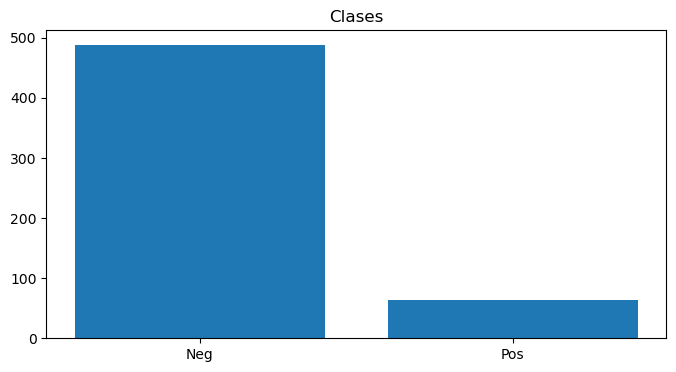

In [8]:
graficarClases(df['Class'])

In [9]:
initial_bias = np.log([pos/neg])

In [10]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
Weight for class 1: 4.31


# Dividir Datos

In [11]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.2)

# Normalizar

In [12]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Construccion

## Modelo

## Optimizador

In [13]:
n_features = len(features)
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
n_epochs = 1000

In [14]:
output_path = 'ajustes/'
output_path_model = 'modelos/'
N = 20


In [15]:
def entrenar(name_prj, base_model_path, n_steps_in,n_steps_out):
    name_prj = name_prj + str(n_steps_out) +'_'+fecha_hora
    
    # --------------------- Entrenamiento --------------------------------------
    x_train, y_train = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
    x_test, y_test = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
    batch_learning = len(x_train)

    prcs = []
    models = []
    res_path = output_path_model+name_prj+".csv"
    print_line("loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc\n",res_path)

    print("Entrenando...")
    for i in range(N):
        name_model = output_path_model+name_prj+'_'+str(i)+'.h5'
        model = load_model(base_model_path)
        # Condicion de parada: 10 epocas despues del menor val_loss
        es_t = EarlyStopping(
            monitor='val_prc', 
            verbose=0,
            patience=50,
            mode='max',
            restore_best_weights=True)
        models.append(name_model)
        history = model.fit(x=x_train, y=y_train, validation_split = 0.3, epochs = n_epochs
            , verbose = 0, shuffle = False, callbacks = [es_t], batch_size = batch_learning, class_weight=class_weight)

        model.save(name_model) 
        #plot_metrics(history)

        # --------------------- Evaluacion --------------------------------------
        res = model.evaluate(x_test, y_test,
                                        batch_size=batch_learning, verbose=0)
        print_line(f'{res[0]},{res[1]},{res[2]},{res[3]},{res[4]},{res[5]},{res[6]},{res[7]},{res[8]},{res[9]}\n', res_path)
        prcs.append(res[9]) #guarda metrica a comparar

    #--------- Evaluando el mejor ------------------------
    print("Evaluando mejor...")
    best_model = models[np.argmax(prcs)]
    print(f'\nMejor modelo: {best_model} con prc: {np.max(prcs)}\n')

    model = load_model(best_model)
    train_predictions = model(x_train) #, batch_size=batch_learning
    test_predictions = model(x_test)

    plot_cm(y_test, test_predictions)
    plot_roc(y_train, train_predictions, y_test, test_predictions)
    plot_prc(y_train, train_predictions, y_test, test_predictions)
    plot_probs(y_train, train_predictions, 'Train')
    plot_probs(y_test, test_predictions, 'Test')

# Entrenar

# MLP

## 1 Mes

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/MLP_USA_1_20221230_1601_0.h5 con prc: 0.375

Expansiones Detectadas (Verdadero Negativos):  85
Expansiones Incorrecas Detectadas (Falso Positivos):  9
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  3
Total de Recesiones:  3


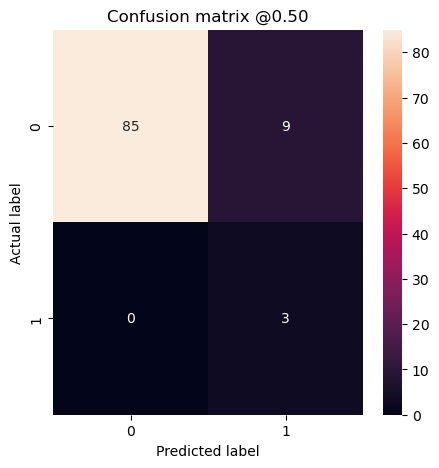

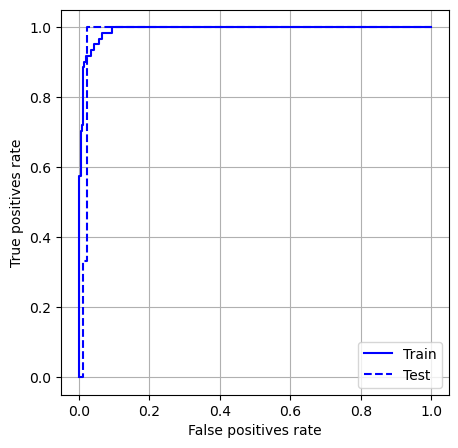

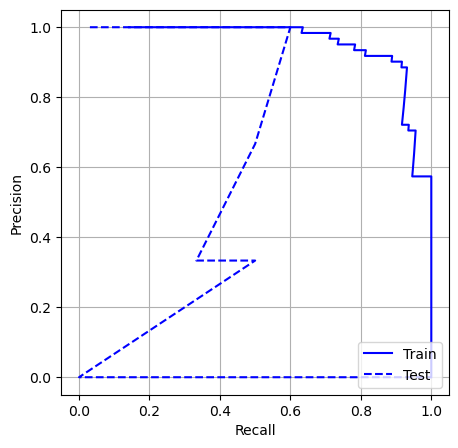

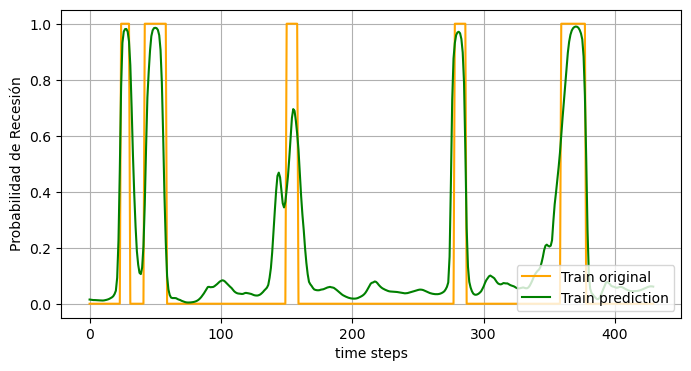

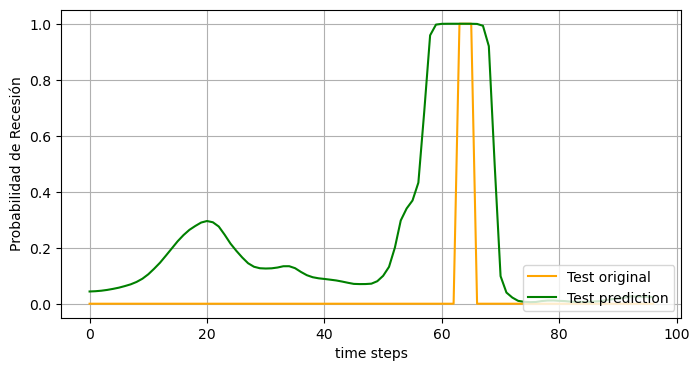

In [21]:
steps_in = 13
steps_out = 1
name_prj = 'MLP_USA_'
model_path = 'ajustes/MLP_USA_1_20221230_0347.h5'
entrenar(name_prj,model_path, steps_in, steps_out)

## 6 meses

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/MLP_USA_6_20221230_1601_9.h5 con prc: 0.4285714328289032

Expansiones Detectadas (Verdadero Negativos):  77
Expansiones Incorrecas Detectadas (Falso Positivos):  9
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  3
Total de Recesiones:  3


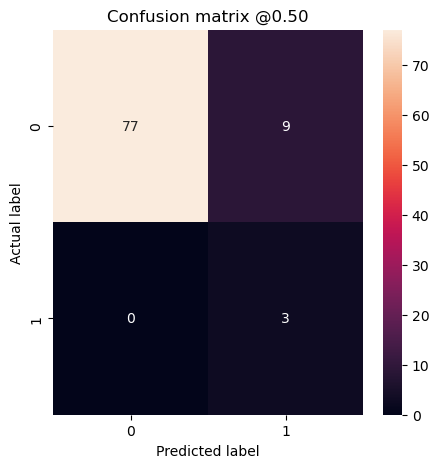

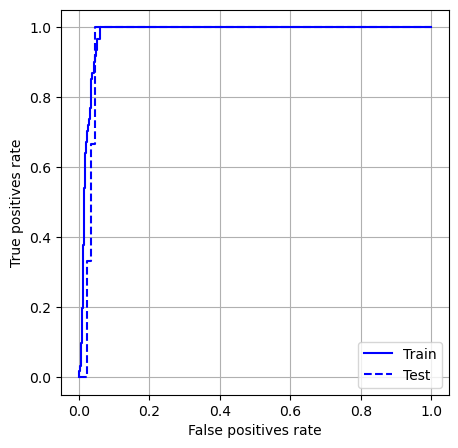

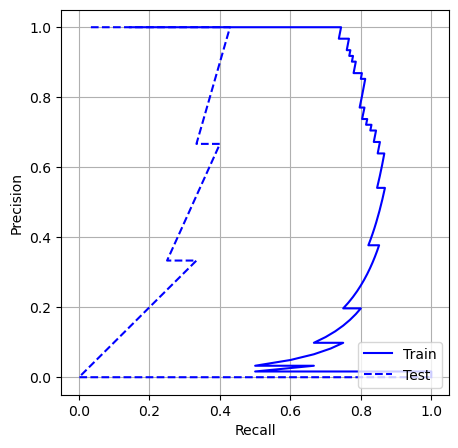

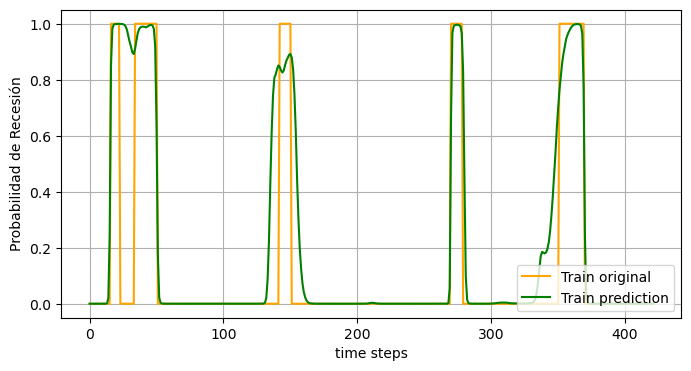

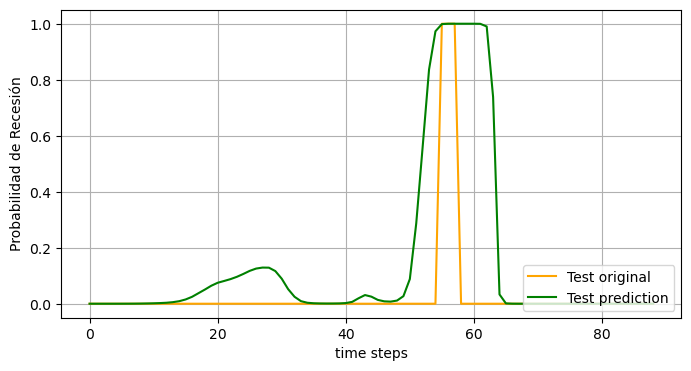

In [22]:
steps_in = 16
steps_out = 6
name_prj = 'MLP_USA_'
model_path = 'ajustes/MLP_USA_6_20221230_0347.h5'
entrenar(name_prj,model_path, steps_in, steps_out)

## 12 Meses

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/MLP_USA_12_20221230_1601_17.h5 con prc: 0.5310450792312622

Expansiones Detectadas (Verdadero Negativos):  78
Expansiones Incorrecas Detectadas (Falso Positivos):  3
Recesiones no Detectadas (False Negativos):  1
Recesiones Detectadas (Verdadero Positivos):  2
Total de Recesiones:  3


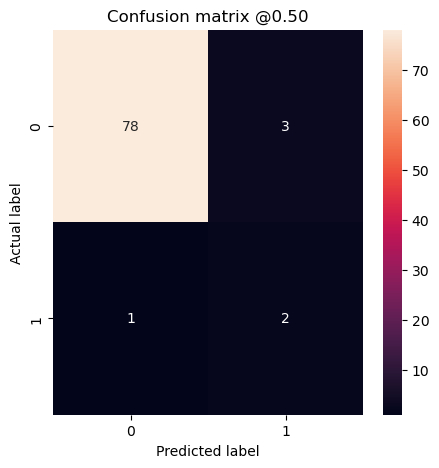

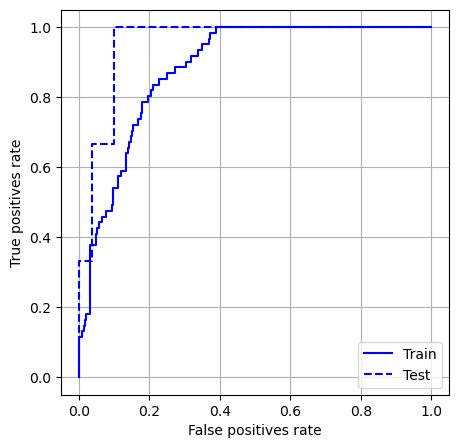

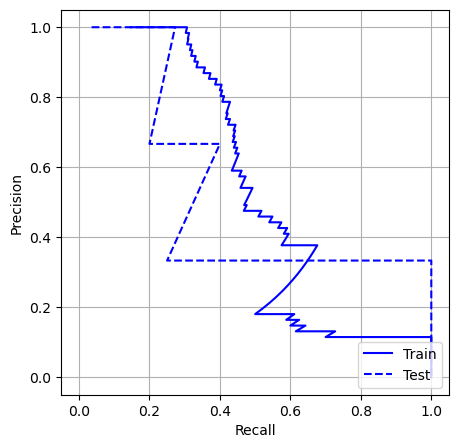

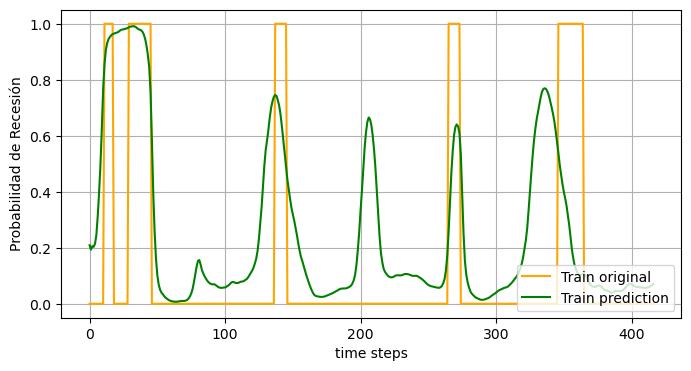

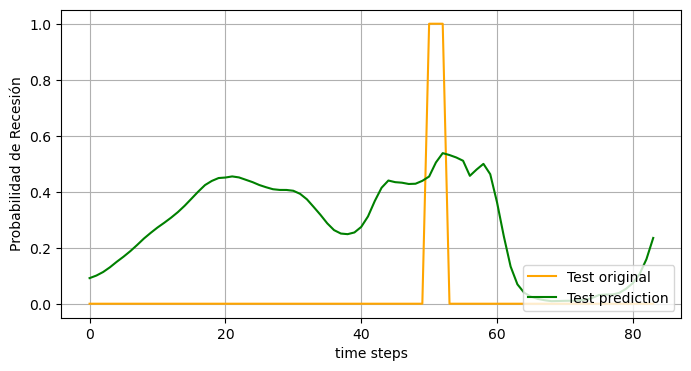

In [29]:
steps_in = 15
steps_out = 12
name_prj = 'MLP_USA_'
model_path = 'ajustes/MLP_USA_12_20221230_1551.h5'
entrenar(name_prj,model_path, steps_in, steps_out)

# CNN

## 1 Mes

Entrenando...


2022-12-30 17:05:37.361623: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-30 17:05:39.025953: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-12-30 17:05:40.612086: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Evaluando mejor...

Mejor modelo: modelos/CNN_USA_1_20221230_1705_19.h5 con prc: 0.4285714328289032

Expansiones Detectadas (Verdadero Negativos):  76
Expansiones Incorrecas Detectadas (Falso Positivos):  14
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  3
Total de Recesiones:  3


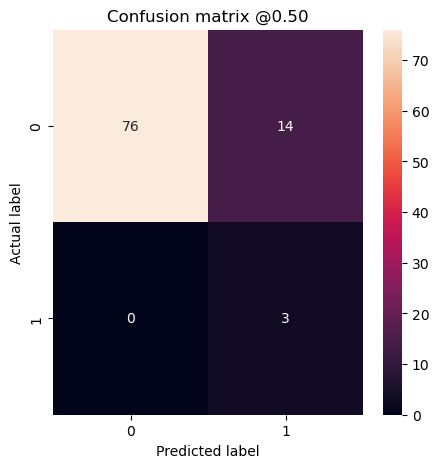

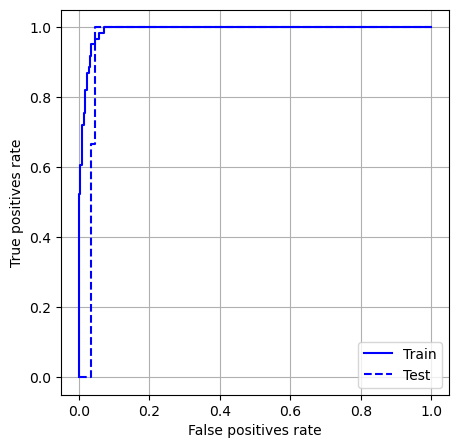

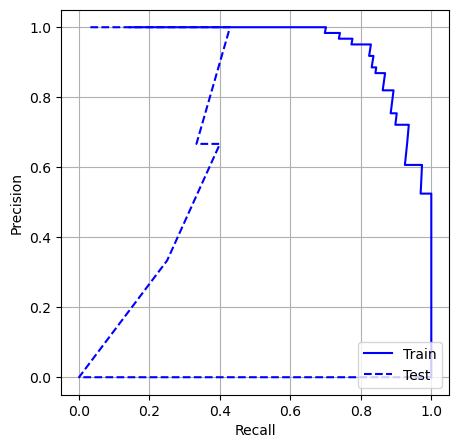

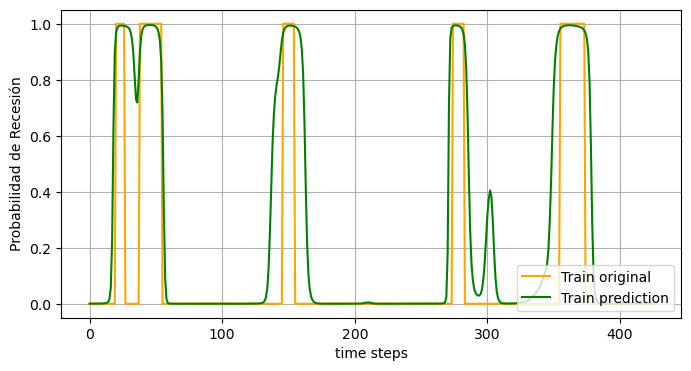

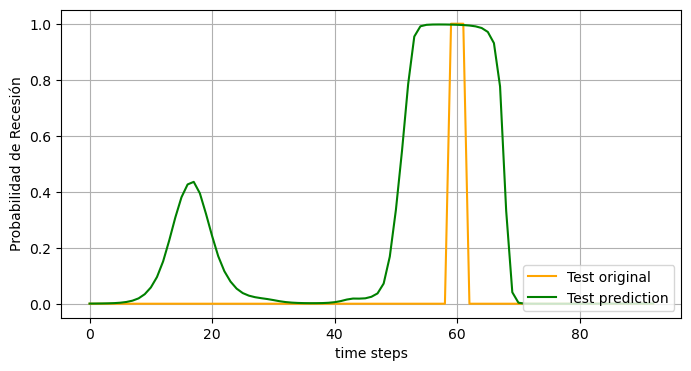

In [17]:
steps_in = 17
steps_out = 1
name_prj = 'CNN_USA_'
model_path = 'ajustes/CNN_USA_1_20221230_0037.h5'
entrenar(name_prj,model_path, steps_in, steps_out)

## 6 Meses

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/CNN_USA_6_20221230_1705_0.h5 con prc: 1.0

Expansiones Detectadas (Verdadero Negativos):  78
Expansiones Incorrecas Detectadas (Falso Positivos):  11
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  3
Total de Recesiones:  3


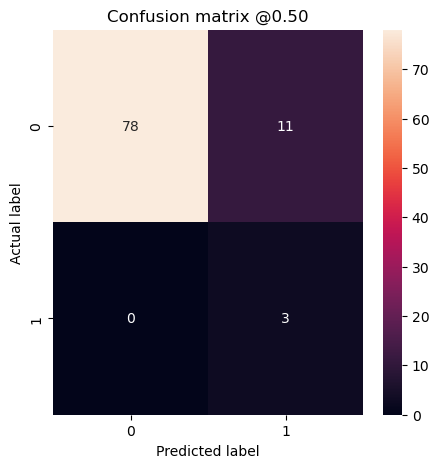

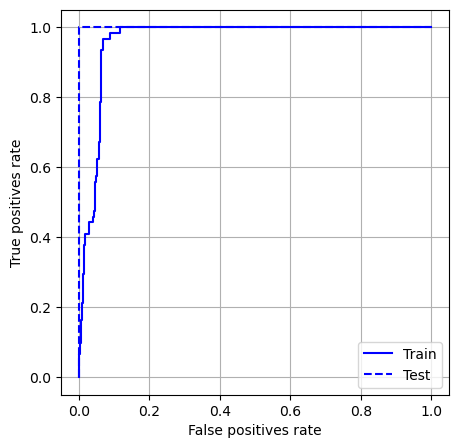

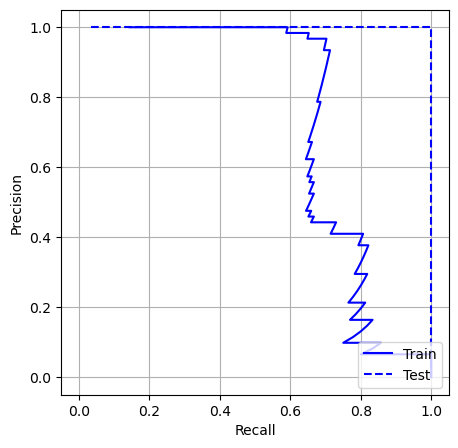

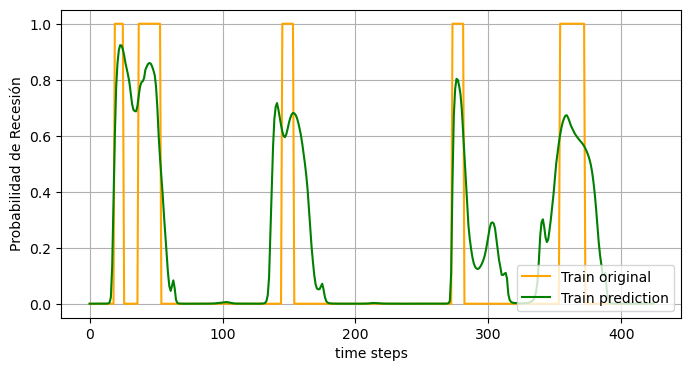

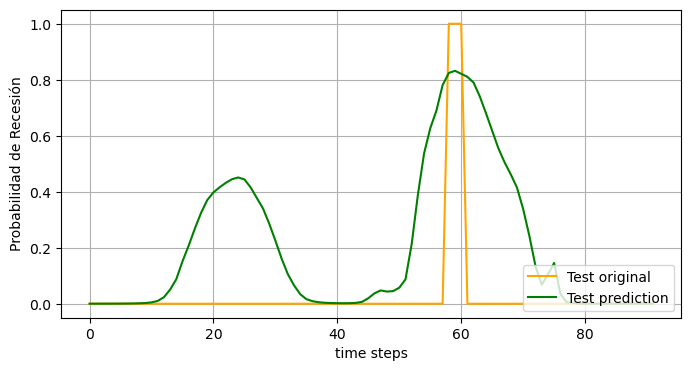

In [18]:
steps_in = 13
steps_out = 6
name_prj = 'CNN_USA_'
model_path = 'ajustes/CNN_USA_6_20221230_0037.h5'
entrenar(name_prj,model_path, steps_in, steps_out)

## 12 Meses

Entrenando...
Evaluando mejor...

Mejor modelo: modelos/CNN_USA_12_20221230_1705_3.h5 con prc: 0.2198036015033722

Expansiones Detectadas (Verdadero Negativos):  74
Expansiones Incorrecas Detectadas (Falso Positivos):  0
Recesiones no Detectadas (False Negativos):  3
Recesiones Detectadas (Verdadero Positivos):  0
Total de Recesiones:  3


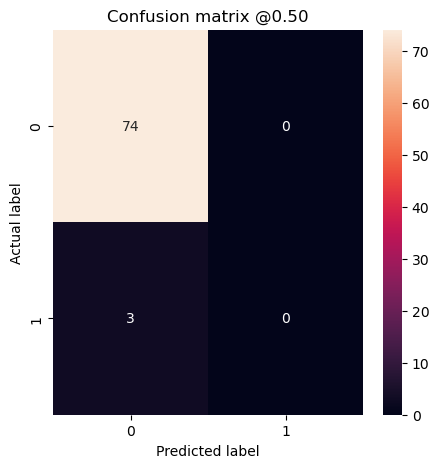

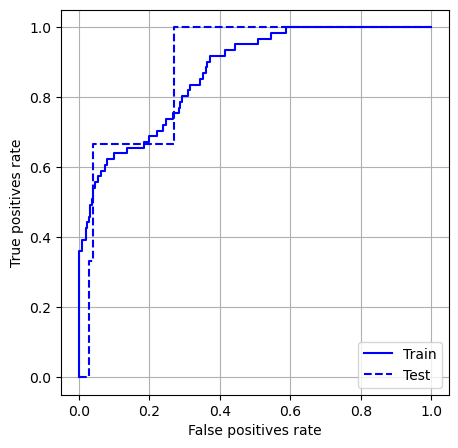

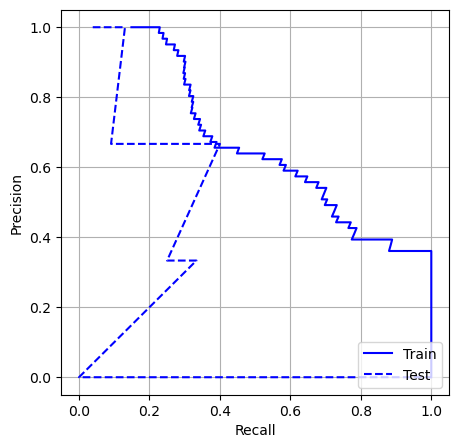

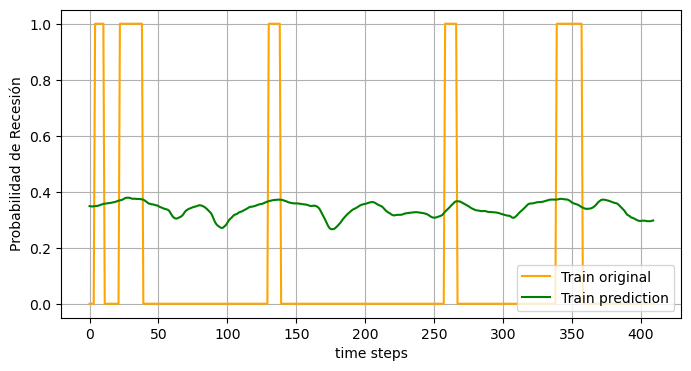

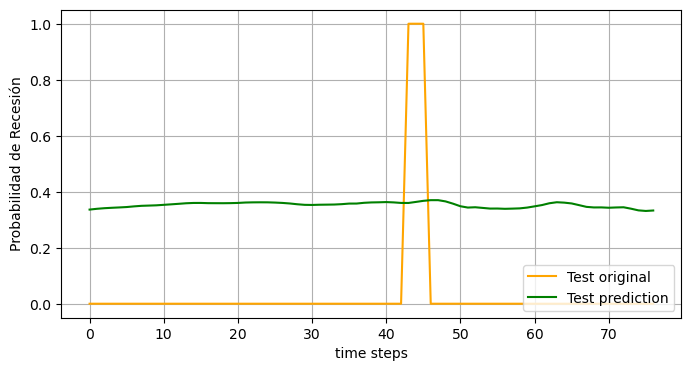

In [19]:
steps_in = 22
steps_out = 12
name_prj = 'CNN_USA_'
model_path = 'ajustes/CNN_USA_12_20221230_0037.h5'
entrenar(name_prj,model_path, steps_in, steps_out)